# Image Classification using AWS Sagemaker <br/> Dog Identification App using Transfer Learning (Pytorch ResNet50)

In theis project we use AWS Sagemaker to train a pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices. This can be done on the provided dog breed classication data set.

We use Pytorch pretreained ResNet50 model for transfer learning. Resnet 50 is a pretrained convolutional neural network. We fine tune Resnet 50 using transfer learning techniques to classify dog breeds from images.

Our training scripts can take advantage of Amazon EC2 GPU-based parallel compute capabilities using Pytorch and CUDA. They can utilize Multi-GPU insances using Pytorch `DataParallel()` model.


In [2]:
IAM_ROLE = "arn:aws:iam::995409147735:role/fady_execution_role"
BUCKET = 'fady-aws-mlnd-dog-images-classification'

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [6]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.pytorch import PyTorch

import os
import math

from glob import glob

import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

The provided dataset is the dogbreed classification dataset which can be downloaded from this [link](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

The dataset contains images for 133 dog breeds, organized into train, validatin and test datasets. The train and validation are used during the training phase of the model, while the test dataset is used to evaluate the model after each training epoch.

Training set contains 6680 images, Validation set contains 835 images and test set contains 836 images.


The dog breed names are listed in the following cell:

In [7]:
dog_names = [item[25:-1] for item in sorted(glob("data/dogImages/train/*/"))] # load list of dog names
print(np.array(dog_names))

['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute' 'American_eskimo_dog' 'American_foxhound'
 'American_staffordshire_terrier' 'American_water_spaniel'
 'Anatolian_shepherd_dog' 'Australian_cattle_dog' 'Australian_shepherd'
 'Australian_terrier' 'Basenji' 'Basset_hound' 'Beagle' 'Bearded_collie'
 'Beauceron' 'Bedlington_terrier' 'Belgian_malinois' 'Belgian_sheepdog'
 'Belgian_tervuren' 'Bernese_mountain_dog' 'Bichon_frise'
 'Black_and_tan_coonhound' 'Black_russian_terrier' 'Bloodhound'
 'Bluetick_coonhound' 'Border_collie' 'Border_terrier' 'Borzoi'
 'Boston_terrier' 'Bouvier_des_flandres' 'Boxer' 'Boykin_spaniel' 'Briard'
 'Brittany' 'Brussels_griffon' 'Bull_terrier' 'Bulldog' 'Bullmastiff'
 'Cairn_terrier' 'Canaan_dog' 'Cane_corso' 'Cardigan_welsh_corgi'
 'Cavalier_king_charles_spaniel' 'Chesapeake_bay_retriever' 'Chihuahua'
 'Chinese_crested' 'Chinese_shar-pei' 'Chow_chow' 'Clumber_spaniel'
 'Cocker_spaniel' 'Collie' 'Curly-coated_retriever' 'Dachshund'
 '

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!mkdir data
!aws s3 cp s3://udacity-aind/dog-project/dogImages.zip ./data/ --no-sign-request

mkdir: cannot create directory ‘data’: File exists
download: s3://udacity-aind/dog-project/dogImages.zip to data/dogImages.zip


In [8]:
%%bash
cd data
unzip dogImages.zip

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg  
   creating: dogImages/test/002.Afghan_hound/
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg  
  inflating: dogImages/test/002.Afghan_hound/Afghan_ho

In [62]:
os.environ["default_s3_bucket"] = BUCKET
!aws s3 sync data/dogImages/  s3://${default_s3_bucket}/data/ 

upload: data/dogImages/test/003.Airedale_terrier/Airedale_terrier_00166.jpg to s3://fady-aws-mlnd-dog-images-classification-light/data/test/003.Airedale_terrier/Airedale_terrier_00166.jpg
upload: data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://fady-aws-mlnd-dog-images-classification-light/data/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: data/dogImages/test/009.American_water_spaniel/American_water_spaniel_00624.jpg to s3://fady-aws-mlnd-dog-images-classification-light/data/test/009.American_water_spaniel/American_water_spaniel_00624.jpg
upload: data/dogImages/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00538.jpg to s3://fady-aws-mlnd-dog-images-classification-light/data/test/008.American_staffordshire_terrier/American_staffordshire_terrier_00538.jpg
upload: data/dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00406.jpg to s3://fady-aws-mlnd-dog-images-classification-light/data/test/006.American_eskimo_dog/American_e

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In this section we will tune `learning_rate` and `batch_size` parameters. Both of these two parameters can affect the speed of conversion and the accuracy of the model.

`learning_rate` will be in the range $(0.001, 0.1)$ and `batch_size` will be one from 5 values ($[32, 64, 128, 256, 512]$).

We will run a hyperparameter tuning job that will randomly select parameters from the search space run a training job, then try to guess the next hyperparameters to pick for subsequent training jobs to improve the `Test Loss` metric.

The best training hyperparameters are those that _minimize_ the `Test Loss` metric.

In [9]:
#TODO: Declare your HP ranges, metrics etc.

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

# hyperparameter_ranges = {
#     "learning_rate": ContinuousParameter(0.0899999, 0.09),
#     "batch_size": CategoricalParameter([32, 64]),
# }


role = IAM_ROLE

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    source_dir="code",  # directory of training script
    base_job_name='pytorch-dog-hpo',
    role=role,
    framework_version="1.9", # 1.4.0
    instance_count=1,
    instance_type="ml.m5.2xlarge", #You can use GPU instance ml.p2.xlarge or standard instance ml.m5.large or local
    py_version='py38' # py3
) # TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    base_tuning_job_name = 'pytorch-dog-hpo-tuning',
    objective_type=objective_type
) # TODO: Your HP tuner here

In [5]:
BUCKET

'fady-aws-mlnd-dog-images-classification'

In [12]:
# TODO: Fit your HP Tuner

tuner.fit({"training": f"s3://{BUCKET}/data/"}, wait=False) # TODO: Remember to include your data channels

In [18]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-dog-hpo-tuni-220117-0020',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:995409147735:hyper-parameter-tuning-job/pytorch-dog-hpo-tuni-220117-0020',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"', '"256"', '"512"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_

In [19]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()
best_estimator_hyperparameters


2022-01-16 23:42:58 Starting - Preparing the instances for training
2022-01-16 23:42:58 Downloading - Downloading input data
2022-01-16 23:42:58 Training - Training image download completed. Training in progress.
2022-01-16 23:42:58 Uploading - Uploading generated training model
2022-01-16 23:42:58 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.002885169972039605',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-dog-hpo-2022-01-16-22-20-54-486"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-995409147735/pytorch-dog-hpo-2022-01-16-22-20-54-486/source/sourcedir.tar.gz"'}

In [20]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-dog-hpo-tuni-220117-0020'

In [10]:
#Load tuning job
#tuner = HyperparameterTuner.attach('pytorch-dog-hpo-tuni-220117-0020')

In [21]:
tuner.analytics().dataframe()
#see sagemaker analytics https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning 

batch_size  learning_rate                                TrainingJobName  \
0      "256"       0.014120  pytorch-dog-hpo-tuni-220117-0020-004-30d11567   
1       "32"       0.002885  pytorch-dog-hpo-tuni-220117-0020-003-8cc229d5   
2      "512"       0.001267  pytorch-dog-hpo-tuni-220117-0020-002-79a70b44   
3      "128"       0.042533  pytorch-dog-hpo-tuni-220117-0020-001-ceff5c55   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed             2.331930 2022-01-17 01:47:26+02:00   
1         Completed             1.171263 2022-01-17 01:22:36+02:00   
2         Completed             2.497905 2022-01-17 00:52:48+02:00   
3         Completed             4.859371 2022-01-17 00:23:33+02:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2022-01-17 02:10:11+02:00                      1365.0  
1 2022-01-17 01:42:58+02:00                      1222.0  
2 2022-01-17 01:15:49+02:00                      1381.0  
3 2022-01-17 00:46:23+02:00                      1370.0

In [24]:
# Best hyperparameters found:
hyperparameters = {"batch_size": int(best_estimator_hyperparameters['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator_hyperparameters['learning_rate']}

hyperparameters

{'batch_size': 32, 'learning_rate': '0.002885169972039605'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [28]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule, #profiler
    ProfilerConfig, #profiler
    FrameworkProfile, #profiler
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": str(math.ceil(6813 / hyperparameters['batch_size'])) , #213 "13"
        "eval.save_interval": str(math.ceil(968 / hyperparameters['batch_size'])), #31 "5"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [32]:
local_mode = False #Local mode is used for testing the algorithm on local machine

if local_mode:
    instance_type = "local"
    entry_point = 'hpo.py'
    data_location = f"file://./data/dogImages"
    output_location=f"file://./output/"
    base_job_name = 'dog-pytorch-local'
    debug_profiler_prameters = {}
else:
    instance_type = "ml.p2.xlarge"
    entry_point = 'train_model.py'
    data_location = f"s3://{BUCKET}/data/"
    output_location=f"s3://{BUCKET}/output/"
    base_job_name = 'dog-pytorch'
    ## Debugger and Profiler parameters
    debug_profiler_prameters = {
        'rules' : rules,
        'debugger_hook_config' : hook_config,
        'profiler_config' : profiler_config,
    }

In [34]:
# test  ml.m5.large,  ml.m5.xlarge and ml.p2.xlarge 
# instance_type = "ml.p3.2xlarge"
# base_job_name = 'dog-pytorch-test-' + instance_type.replace('.', '-')
# entry_point = 'hpo.py'
# data_location = f"s3://{BUCKET}/data/"
# output_location=f"s3://{BUCKET}/instance-testing/output/"
# debug_profiler_prameters = {}

In [35]:
metric_definitions=[
                    {"Name": "Train Loss", "Regex": "train loss: ([0-9\\.]+), acc: [0-9\\.]+.*"},
                    {'Name': 'Validation Loss', 'Regex': "valid loss: ([0-9\\.]+), acc: [0-9\\.]+.*"},
                    {"Name": "Train Accuracy", "Regex": "train loss: [0-9\\.]+, acc: ([0-9\\.]+).*"},
                    {'Name': 'Validation Accuracy', 'Regex': "valid loss: [0-9\\.]+, acc: ([0-9\\.]+).*"},
                   ]

In [44]:
# TODO: Create and fit an estimator


#hyperparameters = {'batch_size': 32, 'learning_rate': '0.002885169972039605'}
hyperparameters = {"batch_size": int(best_estimator_hyperparameters['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator_hyperparameters['learning_rate']}

estimator = PyTorch( # TODO: Your estimator here
    entry_point=entry_point,
    source_dir="code",  # directory of training script
    base_job_name=base_job_name,
    role=role,
    instance_count=1,
    instance_type=instance_type, 
    framework_version='1.9',
    py_version='py38',
    hyperparameters=hyperparameters,
    output_path=output_location,
    metric_definitions=metric_definitions,
    **debug_profiler_prameters
)

estimator.fit({"training": data_location}, wait=False)

In [102]:
# Get training job first logs 
client = boto3.client('logs')
response = client.get_log_events(
    logGroupName='/aws/sagemaker/TrainingJobs',
    logStreamName='dog-pytorch-2022-01-17-05-12-44-384/algo-1-1642396554',
#    startTime=int((datetime.today() - timedelta(hours=5)).timestamp()),
#    endTime=int(datetime.now().timestamp()),
#    nextToken='string',
    limit=115,
    startFromHead=True,
)

log_events = response['events']
for each_event in log_events:
    print(each_event['message'])
    


bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-17 05:22:24,749 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-17 05:22:24,773 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-17 05:22:25,411 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-17 05:22:26,458 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 32,
        "learning_rate": "0.002885169972039605"
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
        "traini

In [45]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : dog-pytorch-2022-01-17-05-12-44-384

latest_job_debugger_artifacts_path : s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/debug-output

rule_output_path : s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output



In [6]:
# Load Pytorch Estimator
#estimator = PyTorch.attach('dog-pytorch-test-ml-p2-xlarge-2022-01-15-02-46-11-720')


2022-01-15 03:00:29 Starting - Preparing the instances for training
2022-01-15 03:00:29 Downloading - Downloading input data
2022-01-15 03:00:29 Training - Training image download completed. Training in progress.
2022-01-15 03:00:29 Uploading - Uploading generated training model
2022-01-15 03:00:29 Completed - Training job completed


In [47]:
# TODO: Plot a debugging output.

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-17 08:26:12.115 nb1:221570 INFO s3_trial.py:42] Loading trial debug-output at path s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/debug-output


[2022-01-17 08:27:12.969 nb1:221570 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-01-17 08:27:14.137 nb1:221570 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


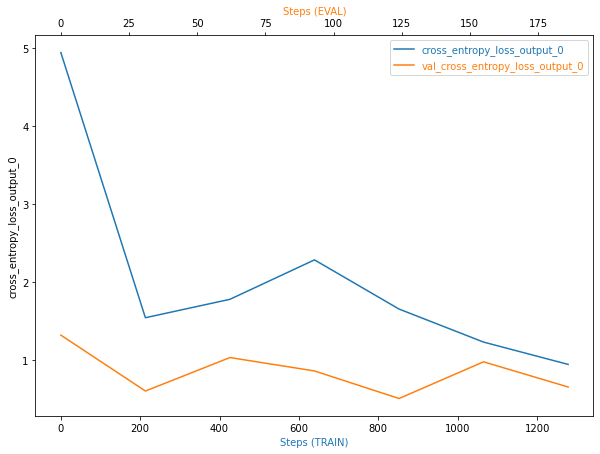

In [48]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "cross_entropy_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Plotting learning curves gives insights about the training algorithm. It can show wheter the algoritm performance over time. It can also diagnose underfitting and overfitting problems.  
Underitting  and overfitting problems are detected from validation learning curve. Underfitting is detected from validation score that doesn't improve over time. overfitting is when the training curve keeps improving while the validation is getting worse.
Errors can be fixed by adjusting learning rate, batch size and getting more data samples.

In [ ]:
# TODO: Display the profiler output

In [100]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [101]:
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output
download: s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://fady-aws-mlnd-dog-images-classification/output/dog-pytorch-2022-01-17-05-12-44-384/rule-output/ProfilerRepo

## Model Deploying

In [103]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

import requests
import json

from PIL import Image
import io

import torch


import base64


In [104]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [106]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            source_dir="code",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)


In [145]:
# TODO: Deploy your model to an endpoint

predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium',
) # TODO: Add your deployment configuration like instance type and number of instances

--------------!

In [146]:
predictor.endpoint_name

'pytorch-inference-2022-01-17-09-00-25-386'

In [14]:
# #Load the predictor from endpoint
# endpoint_name = 'pytorch-inference-2022-01-16-18-17-25-679'
# predictor = sagemaker.predictor.Predictor(endpoint_name, 
#                                            sagemaker_session=None, 
#                                            serializer=jpeg_serializer, 
#                                            deserializer=json_deserializer,
#                                           )

In [ ]:
# TODO: Run the prediction on the endpoint

In [109]:
# Get the labels
dog_names = [item[25:-1] for item in sorted(glob("data/dogImages/train/*/"))] # load list of dog names

In [136]:
# TODO: Your code to load and preprocess image to send to endpoint for prediction

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def display_prediction(url):
    request_dict={ "url": url }
    image_bytes = requests.get(request_dict['url']).content
    response=predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
    display(Image.open(io.BytesIO(image_bytes)))
    logits = np.array(response[0])
    predicted_index = np.argmax(logits)
    print(f"Identified breed: {dog_names[predicted_index]}")
    print(f"Probability: {softmax(logits)[predicted_index]}")

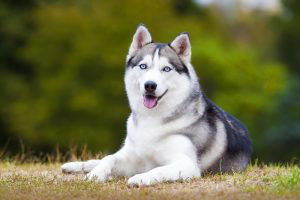

Identified breed: Alaskan_malamute
Probability: 0.9938423599218964


In [137]:
display_prediction("https://vetwork.co/galaxy/wp-content/uploads/siberian-husky-1-300x200.jpg")

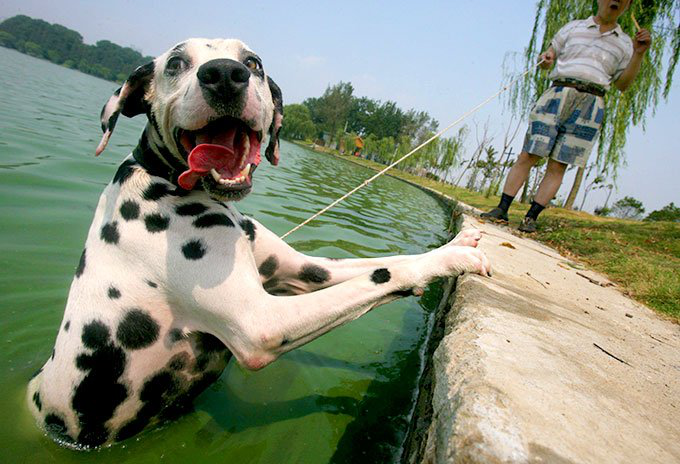

Identified breed: Dalmatian
Probability: 0.9985214384552462


In [139]:
display_prediction("https://dogtime.com/assets/uploads/gallery/dalmatian-dog-breed-pictures/10-water.jpg")

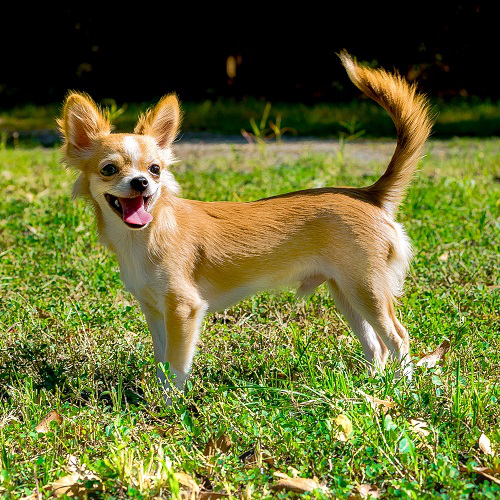

Identified breed: Chihuahua
Probability: 0.6600692810142548


In [140]:
display_prediction("https://www.greencrossvets.com.au/wp-content/uploads/2019/05/Chihuahua-6.jpg")

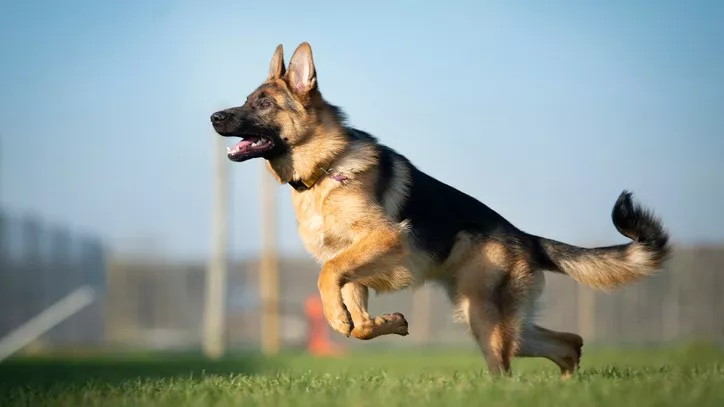

Identified breed: German_shepherd_dog
Probability: 0.8825945890180469


In [141]:
display_prediction("https://cdn.mos.cms.futurecdn.net/Tdom4TwTjsVFLhXrNqnZHS-970-80.jpg.webp")

Got this one wrong!

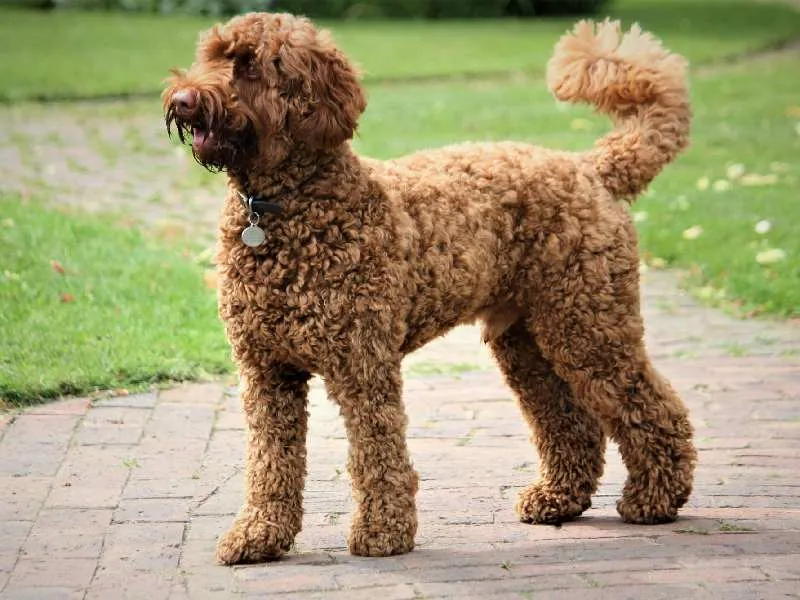

Identified breed: Irish_water_spaniel
Probability: 0.7435483306141114


In [142]:
display_prediction("https://media.kidadl.com/5fae398701e3f4e83bc88ffb-male-poodle-names.jpeg.webp")

In [147]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [47]:
# # Predict using Image URL:
# response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})


# # Predict using boto3 client
# client = boto3.client('sagemaker-runtime')
# content_type = "image/jpeg"                   #"application/json"      
# payload = image_bytes                         #json.dumps(request_dict)  
# response_boto3 = client.invoke_endpoint(
#                                 EndpointName=endpoint_name, 
#                                 ContentType=content_type,
#                                 Body=payload,
#                                 )

# response3 = eval(response_boto3['Body'].read())




# # Predict using aws-cli - url 
# image_base64 = base64.b64encode(json.dumps(request_dict).encode("utf-8")).decode("utf-8") 

# !aws sagemaker-runtime invoke-endpoint \
# --endpoint-url https://runtime.sagemaker.us-east-1.amazonaws.com \
# --endpoint-name $endpoint_name \
# --body $image_base64 \
# --content-type "application/json" \
# ./output/predictions.txt

# with open('output/predictions.txt', 'r') as f:
#     response4 = json.loads(f.read())
# response4

# # Predict using aws-cli - image binary
# image_base64 = base64.b64encode(image_bytes).decode("utf-8") 

# !aws sagemaker-runtime invoke-endpoint \
# --endpoint-url https://runtime.sagemaker.us-east-1.amazonaws.com \
# --endpoint-name $endpoint_name \
# --body $image_base64 \
# --content-type "image/jpeg" \
# ./output/predictions2.txt

# with open('output/predictions2.txt', 'r') as f:
#     response4 = json.loads(f.read())
# response4